In [1]:
%pylab inline
import numpy as np
from matplotlib.pyplot import imread
from scipy.ndimage import gaussian_filter, maximum_filter, minimum_filter

Populating the interactive namespace from numpy and matplotlib


In [2]:
notre_dame_1 = imread('data/Notre Dame/1_o.jpg')
notre_dame_2 = imread('data/Notre Dame/2_o.jpg')

mount_rushmore_1 = imread('data/Mount Rushmore/9021235130_7c2acd9554_o.jpg')
mount_rushmore_2 = imread('data/Mount Rushmore/9318872612_a255c874fb_o.jpg')

episcopal_gaudi_1 = imread('data/Episcopal Gaudi/3743214471_1b5bbfda98_o.jpg')
episcopal_gaudi_2 = imread('data/Episcopal Gaudi/4386465943_8cf9776378_o.jpg')

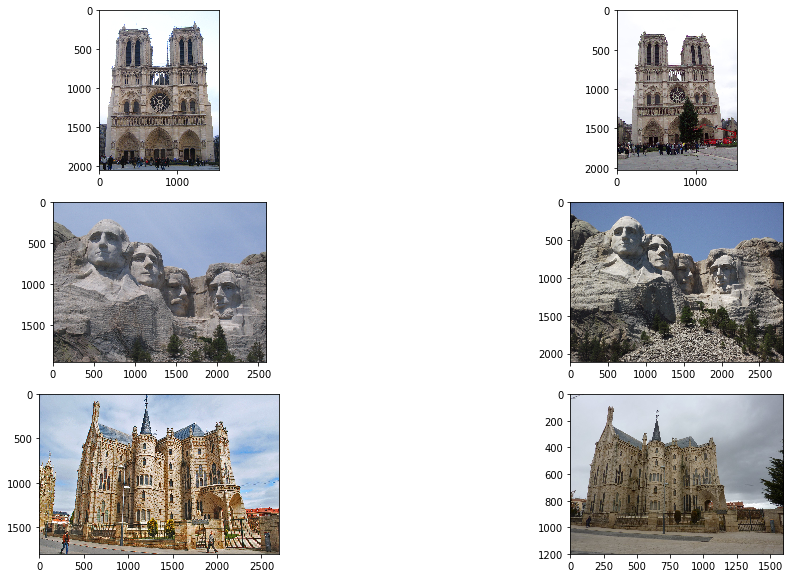

In [3]:
fig = figure(figsize=(17, 10))
ax = fig.subplots(3, 2)
ax[0, 0].imshow(notre_dame_1)
ax[0, 1].imshow(notre_dame_2)
ax[1, 0].imshow(mount_rushmore_1)
ax[1, 1].imshow(mount_rushmore_2)
ax[2, 0].imshow(episcopal_gaudi_1)
ax[2, 1].imshow(episcopal_gaudi_2)

In [3]:
def rgb2y(img):
    return img.dot(np.array([ 0.2989,  0.5866,  0.1145]))

def normalize(img):
    return img / img.max()

In [4]:
notre_dame_1_gs = normalize(rgb2y(notre_dame_1))
notre_dame_2_gs = normalize(rgb2y(notre_dame_2))

mount_rushmore_1_gs = normalize(rgb2y(mount_rushmore_1))
mount_rushmore_2_gs = normalize(rgb2y(mount_rushmore_2))

episcopal_gaudi_1_gs = normalize(rgb2y(episcopal_gaudi_1))
episcopal_gaudi_2_gs = normalize(rgb2y(episcopal_gaudi_2))

In [5]:
def corner_response(img, alpha=0.05, sigma1=None, sigma2=4.):
    if sigma1 is None:
        sigma1 = 0.7 * sigma2
    # image derivatives
    Ix = gaussian_filter(img, sigma=(0, sigma1), order=(0,1))
    Iy = gaussian_filter(img, sigma=(sigma1, 0), order=(1,0))
    # H-matrix elements
    Ixx = Ix * Ix 
    Iyy = Iy * Iy
    Ixy = Ix * Iy
    # convolve with larger Gaussian - sigma2
    g_Ixx = gaussian_filter(Ixx, sigma2)
    g_Ixy = gaussian_filter(Ixy, sigma2)
    g_Iyy = gaussian_filter(Iyy, sigma2)
    # compute corner response
    det = g_Ixx * g_Iyy - g_Ixy * g_Ixy
    trace = g_Ixx + g_Iyy
    return det*(256*256) - alpha * trace

In [6]:
def find_local_maximas_with_threshold(corner_score, neighbourhood_size=5, treshold=0.01):
    # local maximas and minimas
    _max = maximum_filter(corner_score, 5)
    _min = minimum_filter(corner_score, 5)

    # compute maxismas without flat regions
    v = _max - _min
    return np.where(v > v.max() * treshold)

In [7]:
def harris_corners(img, sigma1=1, sigma2=1.5, treshold=0.001, full_output=False):
    R = corner_response(img, sigma1=sigma1, sigma2=sigma2)
    R = R * np.power(sigma2, 5)
    if full_output:
        return find_local_maximas_with_threshold(corner_score=R, treshold=treshold), R
    return find_local_maximas_with_threshold(corner_score=R, treshold=treshold)

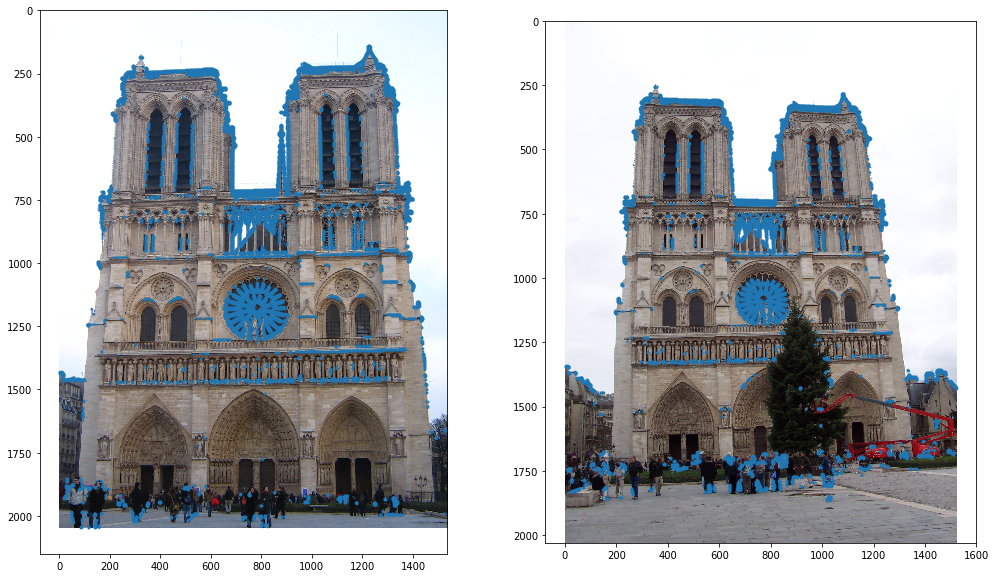

In [19]:
fig = figure(figsize=(17, 10))
ax = fig.subplots(1, 2)
x, y = harris_corners(notre_dame_1_gs, sigma2=1.5, treshold=0.2)
ax[0].imshow(notre_dame_1)
ax[0].scatter(y, x, s=0.1)

x, y = harris_corners(notre_dame_2_gs, sigma2=1.5, treshold=0.2)
ax[1].imshow(notre_dame_2)
ax[1].scatter(y, x, s=0.1)

# Task 2

In [8]:
def anms(harris_response, corner_points, n):
    R = []
    responses = harris_response[corner_points[0], corner_points[1]]
    corner_points = np.hstack((corner_points[0][:, None], corner_points[1][:, None]))
    
    for (i, (y, x)) in enumerate(corner_points):
        bigger_neighbors = corner_points[responses > responses[i]]
        
        if bigger_neighbors.shape[0] == 0:
            radius = np.inf
        else:
            radius = np.sum((bigger_neighbors - np.array([y, x]))**2, 1)
            radius = radius.min()
        R.append(radius)
    
    n = min(len(R), n)
    p = np.argpartition(-np.asarray(R), n)[:n]
    return corner_points[p]

def harris_corners_adaptive_non_maximal_supression(img, n, sigma, treshold=0.001):
    R = corner_response(img, sigma2=sigma)
    R = R * np.power(sigma, 5)
    corner_points = find_local_maximas_with_threshold(corner_score=R, treshold=treshold)
    return anms(R, corner_points, n)

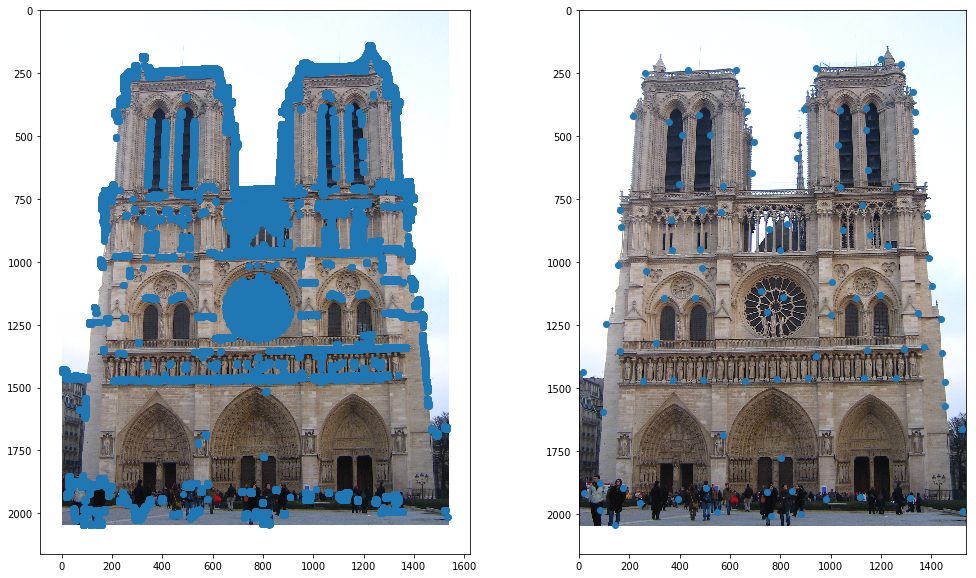

In [20]:
fig = figure(figsize=(17, 10))
ax = fig.subplots(1, 2)
x, y = harris_corners(notre_dame_1_gs, sigma2=1.5, treshold=0.2)
ax[0].imshow(notre_dame_1)
ax[0].scatter(y, x)

p = harris_corners_adaptive_non_maximal_supression(notre_dame_1_gs, n=100, sigma=1.5, treshold=0.2)
ax[1].imshow(notre_dame_1)
ax[1].scatter(p[:,1], p[:, 0])

# Task 3

In [31]:
def harris_laplace(I):
    # from task
    sigma_begin = 1.5
    sigma_step = 1.2
    sigma_n = 13
    sigmas = np.power(sigma_step, np.arange(sigma_n)) * sigma_begin

    # Run harris corners detector for all sigma values, collect results
    points, allpoints, Rs = [], [], []
    for s in sigmas:
        p, R = harris_corners(I, sigma1=0.7*s, sigma2=s, treshold=0.2, full_output=True)
        points.append(p)
        Rs.append(R)
    assert(len(points) == sigma_n)

    print("Before ",  sum(map(lambda x: len(x[1]), points)))

    filtered_points_x = []
    filtered_points_y = []
    filtered_idx = []
    Rs = [np.zeros_like(Rs[0])] + Rs + [np.zeros_like(Rs[-1])]
    for i in range(0,sigma_n):
        sigma = sigmas[i]
        Ra, R, Rb = Rs[i], Rs[i+1], Rs[i+2]
        for x, y in zip(*points[i]):
            if R[x,y] > Ra[x,y] and R[x,y] > Rb[x,y]:
                filtered_points_x.append(x)
                filtered_points_y.append(y)
                filtered_idx.append(i)

    print("After ", len(filtered_points_x))
    return np.array(filtered_points_x), np.array(filtered_points_y), filtered_idx, Rs, points

('Before ', 252127)
('After ', 67010)


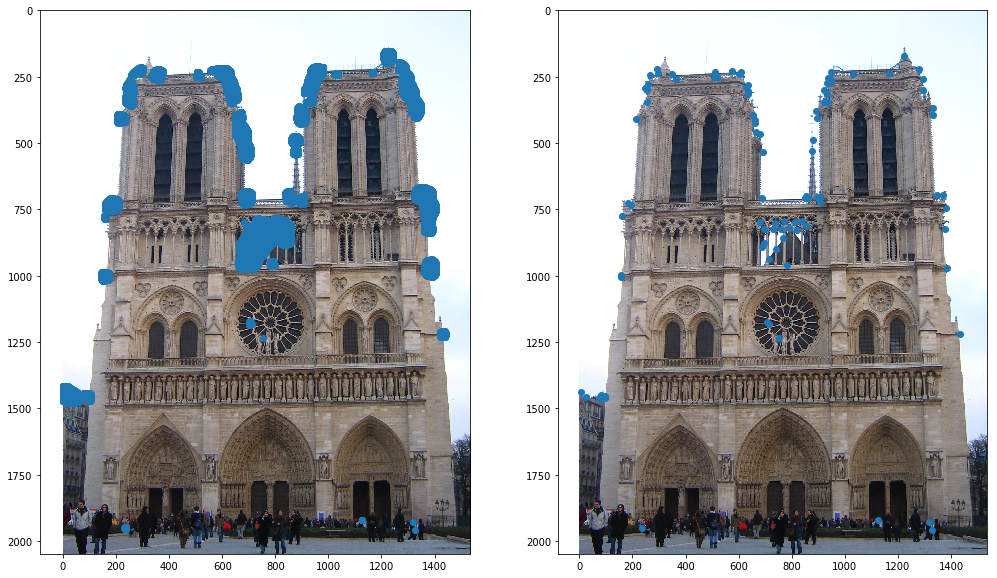

In [32]:
fig = figure(figsize=(17, 10))
ax = fig.subplots(1, 2)
x, y, idx, Rs, points = harris_laplace(notre_dame_1_gs)
R = np.zeros_like(notre_dame_1_gs)
for a, b, i in zip(x, y, idx):
    R[a, b] = Rs[i][a, b]

ax[0].imshow(notre_dame_1)
ax[0].scatter(y, x)

p = anms(R, (x, y), n=100)
ax[1].imshow(notre_dame_1)
ax[1].scatter(p[:,1], p[:, 0])